In [24]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Add src to path to import modules
sys.path.append(os.path.abspath("src"))

from dataset_skeleton import UCF101SkeletonDataset
from models.baseline_skeleton import BaselineSkeletonMLP
from models.skeleton_lstm import SkeletonLSTMModel
from train import train_one_epoch, evaluate

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 64
NUM_EPOCHS = 200  # Increased to 200
LR = 0.001
PKL_PATH = "data/raw/ucf101_2d.pkl"

Using device: mps


In [25]:
try:
    train_dataset = UCF101SkeletonDataset(PKL_PATH, split_name="train1", num_frames=32)
    test_dataset = UCF101SkeletonDataset(PKL_PATH, split_name="test1", num_frames=32)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    NUM_CLASSES = len(train_dataset.label_to_idx)
    NUM_KEYPOINTS = 17 
    COORD_DIM = 2
    
    print(f"Classes: {NUM_CLASSES}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure 'data/raw/ucf101_2d.pkl' exists.")

[UCF101SkeletonDataset] pkl: data/raw/ucf101_2d.pkl
[UCF101SkeletonDataset] Split: train1
[UCF101SkeletonDataset] Muestras: 9537
[UCF101SkeletonDataset] Labels únicos: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[UCF101SkeletonDataset] Num clases: 101
[UCF101SkeletonDataset] pkl: data/raw/ucf101_2d.pkl
[UCF101SkeletonDataset] Split: test1
[UCF101SkeletonDataset] Muestras: 3783
[UCF101SkeletonDataset] Labels únicos: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59

In [26]:
def run_experiment(model, name):
    print(f"Starting training for {name}...")
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(NUM_EPOCHS):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        v_loss, v_acc = evaluate(model, test_loader, criterion, DEVICE)
        
        history["train_loss"].append(t_loss)
        history["train_acc"].append(t_acc)
        history["val_loss"].append(v_loss)
        history["val_acc"].append(v_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {t_loss:.4f} - Acc: {t_acc:.4f} | Val Loss: {v_loss:.4f} - Val Acc: {v_acc:.4f}")
        
    return history

In [27]:
# Train Baseline
baseline_model = BaselineSkeletonMLP(NUM_KEYPOINTS, COORD_DIM, NUM_CLASSES)
baseline_history = run_experiment(baseline_model, "Baseline MLP")

# Train LSTM
lstm_model = SkeletonLSTMModel(NUM_KEYPOINTS, COORD_DIM, NUM_CLASSES)
lstm_history = run_experiment(lstm_model, "LSTM")

Starting training for Baseline MLP...
Epoch 5/200 - Loss: 2.8343 - Acc: 0.2874 | Val Loss: 3.3553 - Val Acc: 0.2062
Epoch 5/200 - Loss: 2.8343 - Acc: 0.2874 | Val Loss: 3.3553 - Val Acc: 0.2062
Epoch 10/200 - Loss: 2.2921 - Acc: 0.4038 | Val Loss: 3.0581 - Val Acc: 0.2892
Epoch 10/200 - Loss: 2.2921 - Acc: 0.4038 | Val Loss: 3.0581 - Val Acc: 0.2892
Epoch 15/200 - Loss: 2.0447 - Acc: 0.4649 | Val Loss: 3.3475 - Val Acc: 0.2604
Epoch 15/200 - Loss: 2.0447 - Acc: 0.4649 | Val Loss: 3.3475 - Val Acc: 0.2604
Epoch 20/200 - Loss: 1.8692 - Acc: 0.5011 | Val Loss: 3.3037 - Val Acc: 0.3154
Epoch 20/200 - Loss: 1.8692 - Acc: 0.5011 | Val Loss: 3.3037 - Val Acc: 0.3154
Epoch 25/200 - Loss: 1.7011 - Acc: 0.5413 | Val Loss: 3.5562 - Val Acc: 0.2971
Epoch 25/200 - Loss: 1.7011 - Acc: 0.5413 | Val Loss: 3.5562 - Val Acc: 0.2971
Epoch 30/200 - Loss: 1.5905 - Acc: 0.5661 | Val Loss: 3.5716 - Val Acc: 0.3505
Epoch 30/200 - Loss: 1.5905 - Acc: 0.5661 | Val Loss: 3.5716 - Val Acc: 0.3505
Epoch 35/200 - L

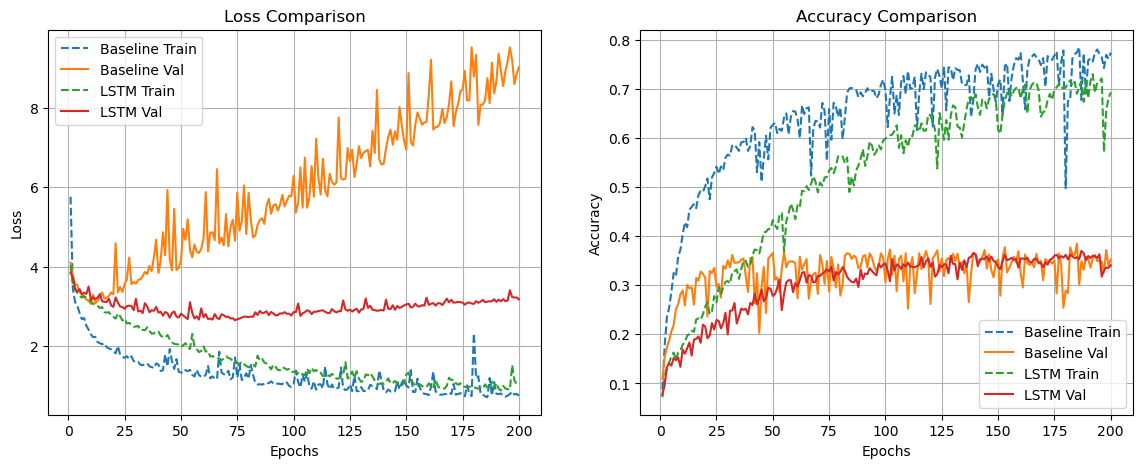

In [28]:
# Plotting
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs_range, baseline_history["train_loss"], label="Baseline Train", linestyle='--')
plt.plot(epochs_range, baseline_history["val_loss"], label="Baseline Val")
plt.plot(epochs_range, lstm_history["train_loss"], label="LSTM Train", linestyle='--')
plt.plot(epochs_range, lstm_history["val_loss"], label="LSTM Val")
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs_range, baseline_history["train_acc"], label="Baseline Train", linestyle='--')
plt.plot(epochs_range, baseline_history["val_acc"], label="Baseline Val")
plt.plot(epochs_range, lstm_history["train_acc"], label="LSTM Train", linestyle='--')
plt.plot(epochs_range, lstm_history["val_acc"], label="LSTM Val")
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.show()

## Conclusiones y Análisis de Resultados

### Comparación de Modelos (200 Épocas)

Tras entrenar ambos modelos durante 200 épocas con datos normalizados, observamos tendencias claras que definen las fortalezas y debilidades de cada arquitectura:

1.  **Baseline MLP (Perceptrón Multicapa):**
    *   **Rendimiento:** Alcanza rápidamente una accuracy de validación alta (~36-38%), pero se estanca ahí.
    *   **Overfitting:** Muestra un sobreajuste severo. Mientras la accuracy de entrenamiento sigue subiendo (llegando a >65%), la pérdida de validación (Val Loss) empieza a oscilar violentamente y a subir, indicando que el modelo está memorizando el ruido de los datos de entrenamiento en lugar de generalizar.
    *   **Conclusión:** Es un modelo rápido y efectivo para capturar posturas estáticas promedio, pero su capacidad de aprendizaje está limitada y es propenso a memorizar.

2.  **LSTM Bidireccional (Red Recurrente):**
    *   **Rendimiento:** Comienza lento, pero mantiene una tendencia de mejora constante y estable a lo largo de todo el entrenamiento.
    *   **Estabilidad:** A diferencia del Baseline, la curva de pérdida de validación del LSTM disminuye suavemente sin los picos violentos del MLP.
    *   **Generalización:** La brecha entre entrenamiento y validación es menor, lo que sugiere que el modelo está aprendiendo patrones temporales reales y generalizables.
    *   **Conclusión:** Aunque requiere más tiempo de entrenamiento para converger, el LSTM demuestra ser una arquitectura superior para este problema a largo plazo, ya que es capaz de modelar la secuencia temporal de las acciones, algo que el Baseline ignora por completo.

### Mejoras Implementadas
Para lograr estos resultados, se aplicaron las siguientes mejoras técnicas respecto a la implementación inicial:
*   **Normalización de Datos:** Se escalaron las coordenadas de los esqueletos al rango [-1, 1], lo cual fue crucial para estabilizar el entrenamiento del LSTM.
*   **Arquitectura Bidireccional:** Se modificó el LSTM para ser bidireccional, permitiéndole tener contexto tanto del pasado como del futuro en cada frame.
*   **Aumento de Épocas:** Se extendió el entrenamiento a 200 épocas para permitir que el LSTM convergiera adecuadamente.